# Análise de sentimento - Comentários de produtos eletrônicos do youtube - Armazenamento no Firebase

In [5]:
from datetime import datetime
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt


import stop_words
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import make_classification
from scikitplot.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report


import imblearn
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from matplotlib import pyplot
from numpy import where


from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE 
# from imblearn.over_sampling import SMOTENC
# from imblearn.over_sampling import SMOTEN
from imblearn.over_sampling import ADASYN 
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import KMeansSMOTE
from imblearn.over_sampling import SVMSMOTE 

import warnings
warnings.filterwarnings('ignore')

In [6]:
df = pd.read_csv('video_comments_final_types.csv')
#video_comments = video_comments.T.reset_index().rename(columns={'index': 'comments_id'})

In [7]:
df['final_type'].count()

4832

In [8]:
df['final_type'].value_counts(normalize=True)

 1.0    0.624586
 0.0    0.326573
-1.0    0.048841
Name: final_type, dtype: float64

In [9]:
df['final_type'].value_counts() #1204 1814 1440 2782

 1.0    3018
 0.0    1578
-1.0     236
Name: final_type, dtype: int64

In [10]:
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

In [11]:
df[['final_type','comment']].loc[df['final_type'] == 1]

,final_type,comment
1,1.0,Assistindo com o meu a51 e agora estou querendo o s21 kkkkkkk
2,1.0,Bom eu tenho problemas e com poeira água e queda
7,1.0,"Celular mt bom, vou comprar um"
9,1.0,Eu tô querendo comprar um sansumg tô com medo a bateria não é tão bao
12,1.0,Faz a comparação dele com A02s
...,...,...
4825,1.0,Eu comprei o moto g9play eu ia comprar esse mais o moto g9play e um pouco melhor.
4826,1.0,"Comprei o meu hoje no magazine Luiza, com o cupom de desconto saiu por 1.759 🤗🤗🤗🤗🤗"
4827,1.0,"Entrada em cima , n gosto ! Gosto de entrada embaixo😏. Rocha Dudu 2020!!!;Brinks Dudu 😂😂sou seu fã."
4828,1.0,Sempre quis dizer isso.... assistindo do meu a71 Prata 🥰😁 ele é tudo de bom ..


<AxesSubplot:xlabel='final_type'>

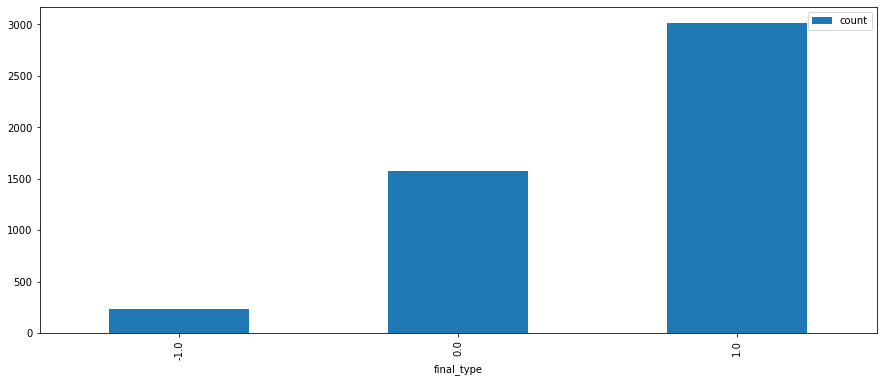

In [12]:
types_dist = df.groupby('final_type').size().reset_index()
types_dist = types_dist.rename(columns={0: 'count'})
types_dist.plot(kind='bar', x="final_type", y="count", figsize=(15,6))

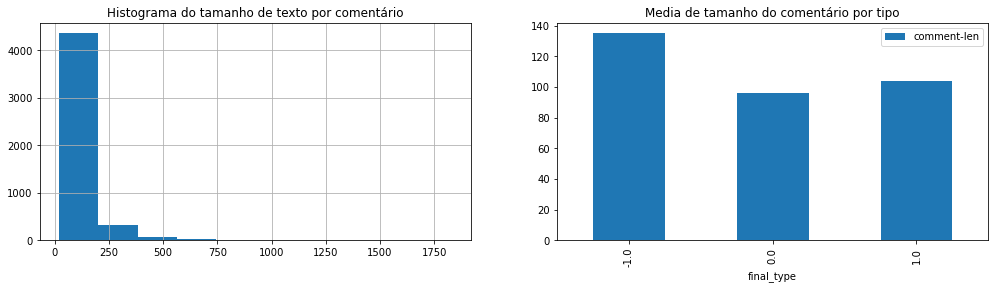

In [13]:
df["comment-len"] = df["comment"].apply(lambda x: len(x))
df_grouped = df.groupby("final_type").agg({'comment-len': 'mean'}).reset_index()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(17,4))

axes[0].set_title("Histograma do tamanho de texto por comentário")
df["comment-len"].hist(ax=axes[0], bins=10)

axes[1].set_title("Media de tamanho do comentário por tipo")
df_grouped.plot.bar(x="final_type", y="comment-len", ax=axes[1])

plt.show()

#  Data Transform

In [14]:
df['comment'] = df['comment'].astype(str)
df['final_type'] = df['final_type'].astype(int)

In [15]:
import string
df['transformed_comment'] =  df['comment'].str.lower()

In [16]:
df['transformed_comment'] = df['transformed_comment'].str.normalize("NFKD").str.encode("ascii", errors="ignore").str.decode("utf8")

In [17]:
import re
import string
regex = re.compile('[%s]' % re.escape(string.punctuation)) #see documentation here: http://docs.python.org/2/library/string.html

tokenized_docs_no_punctuation = []

for review in df['transformed_comment']:
    # new_review = []
    new_review = ""
    for token in review:
        new_token = regex.sub(u'', token)
        if not new_token == u'':
            #new_review.append(new_token)
            new_review = new_review + new_token
        else:
            new_review = new_review + " "
    
    tokenized_docs_no_punctuation.append(new_review)

In [18]:
import nltk
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('portuguese') # removing stop words

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\erycm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
stopwords.append('q')
stopwords.append('pra')
stopwords.append('td')
stopwords.remove('não')

stopwords = pd.DataFrame(stopwords, columns=['normalized'])
stopwords['normalized'] = stopwords['normalized'].str.normalize("NFKD").str.encode("ascii", errors="ignore").str.decode("utf8")

stopword_data = []
count_stopwords = 0
for idx,review in enumerate(tokenized_docs_no_punctuation):
    new_phrase = ""
    for word in review.split(" "):
        # print(word)
        if  not stopwords['normalized'].str.match('^'+word+'$').any():
            new_phrase = new_phrase + " " + word

    stopword_data.append(new_phrase)

In [20]:
# #!pip install git+git://github.com/snowballstem/pystemmer

import Stemmer
stemmer = Stemmer.Stemmer('portuguese')

stemmer_docs = []
for phrase in stopword_data:
    stemmer_docs.append(' '.join(stemmer.stemWords(phrase.split(" "))))
    # stemmer_docs.append(stemmer.stemWords(phrase.split(" ")))


In [21]:
df['transformed_comment'] = stemmer_docs

In [22]:
df[['transformed_comment','comment']]

,transformed_comment,comment
0,porc compr faz 3 mes arrepend bug temp tod reinic volt funcion nao recom vai ser prejuiz decepca compr,Uma porcaria. Comprei faz 3 meses. Muito arrependida. Buga o tempo todo. Tem que reiniciar para voltar a funcionar. Não recomendo. Vai ser prejuízo e decepção para quem comprar...
1,assist a51 agor quer s21 kkkkkkk,Assistindo com o meu a51 e agora estou querendo o s21 kkkkkkk
2,bom problem poeir agu qued,Bom eu tenho problemas e com poeira água e queda
3,samsung vier emoj iphon rend enquant xaiom barat kkkkkkk,Se no Samsung vier os emoji do iPhone eu me rendo 🙇‍♀️🙇‍♀️🙇‍♀️ por enquanto no xaiomi que é mais barato KKKKKKK
4,smartphon gam excelentent msm fiqu desapont pq n vei fon plac vid promet,"Smartphone gamer muito excelentente msm, mas fiquei muito desapontado pq n veio o fone e nem a placa de video q prometia"
...,...,...
4827,entrad cim n gost gost entrad embaix roch dudu 2020 brinks dudu fa,"Entrada em cima , n gosto ! Gosto de entrada embaixo😏. Rocha Dudu 2020!!!;Brinks Dudu 😂😂sou seu fã."
4828,sempr quis diz assist a71 prat tud bom,Sempre quis dizer isso.... assistindo do meu a71 Prata 🥰😁 ele é tudo de bom ..
4829,to doid ganh mot g9 play,To doido pra ganhar o meu moto g9 play
4830,mi 10t pro mi 10 pro,Mi 10t pro ou mi 10 pro?


# Imbalance Apply

In [23]:
def overSamplDef(X_res, y_res, overMethod):
    from collections import Counter
    from imblearn.over_sampling import RandomOverSampler
    from imblearn.over_sampling import SMOTE 
    # from imblearn.over_sampling import SMOTENC
    from imblearn.over_sampling import SMOTEN
    from imblearn.over_sampling import ADASYN 
    from imblearn.over_sampling import BorderlineSMOTE
    from imblearn.over_sampling import KMeansSMOTE
    from imblearn.over_sampling import SVMSMOTE 
    

    print('Before dataset shape %s' % sorted(Counter(y_res).items()))
    ros = overMethod()
    # ros = BorderlineSMOTE()
    # sampling_strategy='minority'
    # ros = SMOTE()
    X_res, y_res = ros.fit_resample(X_res, y_res)

    print('Resampled dataset shape %s' % sorted(Counter(y_res).items()))
    print("-------------------------------------------")


    return X_res, y_res

## Word2Vec

# Create Features

In [24]:
# required_columns = 'comment'
required_columns = 'transformed_comment'
le = LabelEncoder()

X = df[required_columns]
y = le.fit_transform(df['final_type'])

In [25]:
count_vec = CountVectorizer()
X_counts = count_vec.fit_transform(X)
# count_vec_ngram = CountVectorizer(ngram_range=(2, 2))
count_vec_ngram = CountVectorizer(ngram_range=(2, 2))

#count_vec = CountVectorizer(vocabulary=count_vec.vocabulary_)
X_counts_bigram = count_vec_ngram.fit_transform(X)
#X_counts_bigram = count_vec_ngram.transform(X)

tf = TfidfTransformer(use_idf=False, norm="l1")
X_freq = tf.fit_transform(X_counts)

tf = TfidfTransformer(norm="l1")
X_tfidf = tf.fit_transform(X_counts)

In [26]:
X_freq.shape

(4832, 5370)

In [27]:
# X_counts.reshape(-1,1)
# y.reshape(-1,1)

X_train_counts, X_test_counts, y_train_counts, y_test_counts = train_test_split(X_counts, y, test_size=.2)
X_train_bigram, X_test_bigram, y_train_bigram, y_test_bigram = train_test_split(X_counts_bigram, y, test_size=.2)
X_train_freq, X_test_freq, y_train_freq, y_test_freq = train_test_split(X_freq, y, test_size=.2)
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf, y, test_size=.2)

In [28]:
X_train_counts, y_train_counts = overSamplDef(X_train_counts, y_train_counts, SMOTE) #SMOTE or RandomOverSampler | BorderlineSMOTE (pior)
X_train_bigram, y_train_bigram = overSamplDef(X_train_bigram, y_train_bigram, SMOTE) #ADASYN (resultado ruim) | BorderlineSMOTE (mal distribuido)
X_train_freq, y_train_freq = overSamplDef(X_train_freq, y_train_freq, SMOTE) #RandomOverSampler or SMOTE | SVMSMOTE or RandomOverSampler
X_train_tfidf, y_train_tfidf = overSamplDef(X_train_tfidf, y_train_tfidf, SMOTE) #SMOTE | SMOTE


Before dataset shape [(0, 183), (1, 1276), (2, 2406)]
Resampled dataset shape [(0, 2406), (1, 2406), (2, 2406)]
-------------------------------------------
Before dataset shape [(0, 196), (1, 1290), (2, 2379)]
Resampled dataset shape [(0, 2379), (1, 2379), (2, 2379)]
-------------------------------------------
Before dataset shape [(0, 187), (1, 1272), (2, 2406)]
Resampled dataset shape [(0, 2406), (1, 2406), (2, 2406)]
-------------------------------------------
Before dataset shape [(0, 199), (1, 1230), (2, 2436)]
Resampled dataset shape [(0, 2436), (1, 2436), (2, 2436)]
-------------------------------------------


# Training Model

In [29]:
mNB = MultinomialNB()

clf_counts = MultinomialNB().fit(X_train_counts, y_train_counts)
clf_bigram = MultinomialNB().fit(X_train_bigram, y_train_bigram)
clf_freq = MultinomialNB().fit(X_train_freq, y_train_freq)
clf_tfidf = MultinomialNB().fit(X_train_tfidf, y_train_tfidf)

In [30]:
y_pred_counts = clf_counts.predict(X_test_counts)
y_pred_bigram = clf_bigram.predict(X_test_bigram)
y_pred_freq = clf_freq.predict(X_test_freq)
y_pred_tfidf = clf_tfidf.predict(X_test_tfidf)

In [31]:
param_grid = [
  {'C': [1, 10, 100, 1000]}
 ]
svc = LinearSVC()
clf_counts = GridSearchCV(svc, param_grid).fit(X_train_counts, y_train_counts)
clf_bigram = GridSearchCV(svc, param_grid).fit(X_train_bigram, y_train_bigram)
clf_freq = GridSearchCV(svc, param_grid).fit(X_train_freq, y_train_freq)
clf_tfidf = GridSearchCV(svc, param_grid).fit(X_train_tfidf, y_train_tfidf)

In [32]:
svm_y_pred_counts = clf_counts.predict(X_test_counts)
svm_y_pred_bigram = clf_bigram.predict(X_test_bigram)
svm_y_pred_freq = clf_freq.predict(X_test_freq)
svm_y_pred_tfidf = clf_tfidf.predict(X_test_tfidf)

# Check Accuracy

In [33]:
target_names = ['Negativo', 'Neutro', 'Positivo']

print("MNB - Acuracia de counts")
print(classification_report(y_test_counts, y_pred_counts, target_names=target_names))
print("-----------------------------------------------------")
print("MNB - Acuracia de bigram")
print(classification_report(y_test_bigram, y_pred_bigram, target_names=target_names))
print("-----------------------------------------------------")

MNB - Acuracia de counts
              precision    recall  f1-score   support

    Negativo       0.10      0.23      0.14        53
      Neutro       0.38      0.37      0.37       302
    Positivo       0.67      0.60      0.63       612

    accuracy                           0.51       967
   macro avg       0.38      0.40      0.38       967
weighted avg       0.55      0.51      0.52       967

-----------------------------------------------------
MNB - Acuracia de bigram
              precision    recall  f1-score   support

    Negativo       0.06      0.78      0.12        40
      Neutro       0.32      0.32      0.32       288
    Positivo       0.69      0.21      0.32       639

    accuracy                           0.26       967
   macro avg       0.36      0.43      0.25       967
weighted avg       0.55      0.26      0.31       967

-----------------------------------------------------


In [34]:
print("MNB - Acuracia de freq")
print(classification_report(y_test_freq, y_pred_freq, target_names=target_names))
print("-----------------------------------------------------")
print("MNB - Acuracia de tfidf")
print(classification_report(y_test_tfidf, y_pred_tfidf, target_names=target_names))
print("-----------------------------------------------------")

MNB - Acuracia de freq
              precision    recall  f1-score   support

    Negativo       0.07      0.33      0.12        49
      Neutro       0.36      0.41      0.38       306
    Positivo       0.66      0.44      0.52       612

    accuracy                           0.42       967
   macro avg       0.36      0.39      0.34       967
weighted avg       0.53      0.42      0.46       967

-----------------------------------------------------
MNB - Acuracia de tfidf
              precision    recall  f1-score   support

    Negativo       0.10      0.51      0.16        37
      Neutro       0.41      0.38      0.39       348
    Positivo       0.64      0.49      0.55       582

    accuracy                           0.45       967
   macro avg       0.38      0.46      0.37       967
weighted avg       0.53      0.45      0.48       967

-----------------------------------------------------


In [35]:
print("SVM - Acuracia de counts")
print(classification_report(y_test_counts, svm_y_pred_counts, target_names=target_names))
print("-----------------------------------------------------")
print("SVM - Acuracia de bigram")
print(classification_report(y_test_bigram, svm_y_pred_bigram, target_names=target_names))
print("-----------------------------------------------------")

SVM - Acuracia de counts
              precision    recall  f1-score   support

    Negativo       0.09      0.19      0.12        53
      Neutro       0.35      0.41      0.38       302
    Positivo       0.66      0.55      0.60       612

    accuracy                           0.49       967
   macro avg       0.37      0.38      0.37       967
weighted avg       0.54      0.49      0.50       967

-----------------------------------------------------
SVM - Acuracia de bigram
              precision    recall  f1-score   support

    Negativo       0.05      0.50      0.09        40
      Neutro       0.31      0.27      0.29       288
    Positivo       0.69      0.33      0.44       639

    accuracy                           0.32       967
   macro avg       0.35      0.36      0.27       967
weighted avg       0.55      0.32      0.38       967

-----------------------------------------------------


In [36]:
print("SVM - Acuracia de freq")
print(classification_report(y_test_freq, svm_y_pred_freq, target_names=target_names))
print("-----------------------------------------------------")
print("SVM - Acuracia de tfidf")
print(classification_report(y_test_tfidf, svm_y_pred_tfidf, target_names=target_names))

SVM - Acuracia de freq
              precision    recall  f1-score   support

    Negativo       0.04      0.04      0.04        49
      Neutro       0.32      0.33      0.33       306
    Positivo       0.63      0.62      0.62       612

    accuracy                           0.50       967
   macro avg       0.33      0.33      0.33       967
weighted avg       0.50      0.50      0.50       967

-----------------------------------------------------
SVM - Acuracia de tfidf
              precision    recall  f1-score   support

    Negativo       0.10      0.14      0.12        37
      Neutro       0.41      0.36      0.39       348
    Positivo       0.63      0.66      0.65       582

    accuracy                           0.54       967
   macro avg       0.38      0.39      0.38       967
weighted avg       0.53      0.54      0.53       967



In [37]:
print("SVM - Acuracia de freq")
print(classification_report(y_test_freq, svm_y_pred_freq, target_names=target_names))
print("-----------------------------------------------------")
print("SVM - Acuracia de tfidf")
print(classification_report(y_test_tfidf, svm_y_pred_tfidf, target_names=target_names))

SVM - Acuracia de freq
              precision    recall  f1-score   support

    Negativo       0.04      0.04      0.04        49
      Neutro       0.32      0.33      0.33       306
    Positivo       0.63      0.62      0.62       612

    accuracy                           0.50       967
   macro avg       0.33      0.33      0.33       967
weighted avg       0.50      0.50      0.50       967

-----------------------------------------------------
SVM - Acuracia de tfidf
              precision    recall  f1-score   support

    Negativo       0.10      0.14      0.12        37
      Neutro       0.41      0.36      0.39       348
    Positivo       0.63      0.66      0.65       582

    accuracy                           0.54       967
   macro avg       0.38      0.39      0.38       967
weighted avg       0.53      0.54      0.53       967



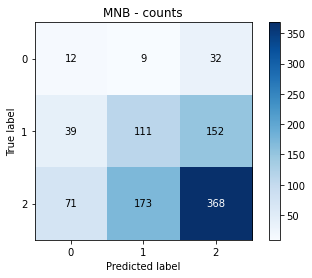

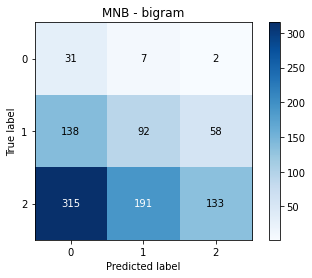

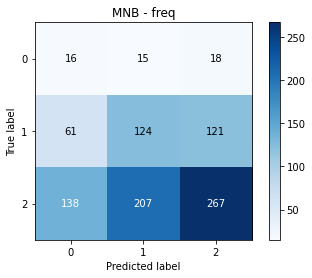

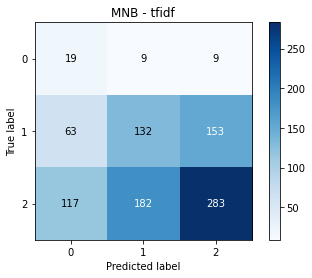

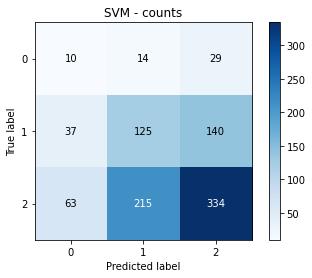

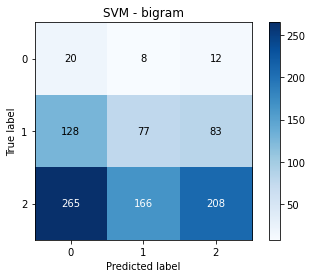

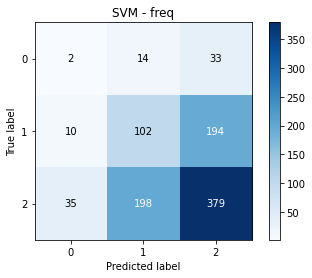

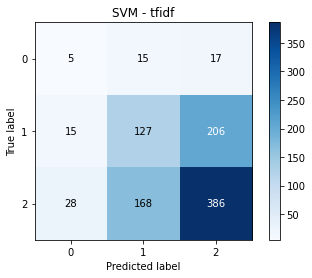

In [38]:
import matplotlib.pyplot as plt

disp = plot_confusion_matrix(y_test_counts, y_pred_counts)
disp.set_title('MNB - counts')
disp = plot_confusion_matrix(y_test_bigram, y_pred_bigram)
disp.set_title('MNB - bigram')
disp = plot_confusion_matrix(y_test_freq, y_pred_freq)
disp.set_title('MNB - freq')
disp = plot_confusion_matrix(y_test_tfidf, y_pred_tfidf)
disp.set_title('MNB - tfidf')

disp = plot_confusion_matrix(y_test_counts, svm_y_pred_counts)
disp.set_title('SVM - counts')
disp = plot_confusion_matrix(y_test_bigram, svm_y_pred_bigram)
disp.set_title('SVM - bigram')
disp = plot_confusion_matrix(y_test_freq, svm_y_pred_freq)
disp.set_title('SVM - freq')
disp = plot_confusion_matrix(y_test_tfidf, svm_y_pred_tfidf)
disp.set_title('SVM - tfidf')


plt.show()